# Citation

Much of the code and examples are copied/modified from 

> Blueprints for Text Analytics Using Python by Jens Albrecht, Sidharth Ramachandran, and Christian Winkler (O'Reilly, 2021), 978-1-492-07408-3.
>

- https://github.com/blueprints-for-text-analytics-python/blueprints-text
- https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb

---

# Setup

In [1]:
cd ../..

/Users/shanekercheval/repos/nlp-template


In [2]:
%run "source/config/notebook_settings.py"

In [3]:
from source.library.utilities import Timer, get_logger
from source.library.text_analysis import count_tokens, tf_idf, get_context_from_keyword, count_keywords, count_keywords_by, impurity

In [4]:
with Timer("Loading Data"):
    path = 'artifacts/data/processed/reddit.pkl'
    df = pd.read_pickle(path)

Started: Loading Data
Finished (0.10 seconds)


---

# Exploratory Data Analysis

This section provides a basic exploration of the text and dataset.

## Dataset Summary

In [5]:
hlp.pandas.numeric_summary(df)

In [6]:
hlp.pandas.non_numeric_summary(df)

,# of Non-Nulls,# of Nulls,% Nulls,Most Freq. Value,# of Unique,% Unique
id,"5,000",0,0.0%,74qv99,"5,000",100.0%
subreddit,"5,000",0,0.0%,Lexus,20,0.4%
title,"5,000",0,0.0%,Need some advice,"4,995",99.9%
post,"5,000",0,0.0%,"Hello, <lb><lb>I have my J32A3[...]","5,000",100.0%
post_clean,"5,000",0,0.0%,"Hello, I have my J32A3 egine o[...]","5,000",100.0%
lemmas,"5,000",0,0.0%,"['hello', 'j32a3', 'egine', 'o[...]","5,000",100.0%
bi_grams,"5,000",0,0.0%,"['j32a3 egine', 'egine open', [...]","5,000",100.0%
adjs_verbs,"5,000",0,0.0%,"['open', 'ready', 'new', 'like[...]","5,000",100.0%
nouns,"5,000",0,0.0%,"['j32a3', 'egine', 'ring', 'j3[...]","5,000",100.0%
noun_phrases,"5,000",0,0.0%,[],"4,992",99.8%


In [7]:
df['subreddit'].value_counts(ascending=False)

Lexus                 266
Hyundai               263
Trucks                262
Honda                 261
MPSelectMiniOwners    260
mercedes_benz         259
mazda3                257
Harley                255
volt                  252
Volkswagen            252
Audi                  252
teslamotors           250
Volvo                 249
Mustang               248
BMW                   239
saab                  239
4Runner               238
Porsche               236
subaru                233
Wrangler              229
Name: subreddit, dtype: int64

In [8]:
df.head(2)

,id,subreddit,title,post,post_clean,lemmas,bi_grams,adjs_verbs,nouns,noun_phrases,adj_noun_phrases,entities,language
10650,74qv99,Honda,J32A3 Block with J35Z2 Crank and Rods?,"Hello, <lb><lb>I have my J32A3 egine open, ready to put new rings and all. I would like to know if I can swap the J35Z2 crank and rods from an Accord Sedan v6 3.5. I would like to keep my pistons,...","Hello, I have my J32A3 egine open, ready to put new rings and all. I would like to know if I can swap the J35Z2 crank and rods from an Accord Sedan v6 _NUMBER_ . I would like to keep my pistons, j...","[hello, j32a3, egine, open, ready, new, ring, like, know, swap, j35z2, crank, rod, accord, sedan, v6, _number_, like, piston, change, rod, crank, little, displacement, doable, option, need, know, ...","[j32a3 egine, egine open, new ring, j35z2 crank, accord sedan, sedan v6, v6 _number_, doable option, acura tl, tl 3, 3 g, g _number_, _number_ manual, manual transmission, classic j35a3]","[open, ready, new, like, know, swap, like, change, little, displacement, doable, need, know, like, know, possible, possible, let, classic]","[j32a3, egine, ring, j35z2, crank, rod, accord, sedan, v6, _number_, piston, rod, crank, option, acura, tl, g, _number_, manual, transmission, difference, j35z2, j35a3, thank, advance]","[egine open, new ring, doable option]","[egine open, new ring, doable option]","[accord (PRODUCT), first (ORDINAL), acura (NORP), 3 (CARDINAL), manual transmission (PERSON)]",English
2041,63r8iz,subaru,Loose wires under passenger seat? (2013 STi),"[img] http://i.imgur.com/BHHkD97.jpg [/img] <lb><lb>Just picked up my car yesterday and while vacuuming it out after driving around alot, I saw these.<lb><lb>Labelled 1 thru 4, what are they for? ...","img _URL_ /img Just picked up my car yesterday and while vacuuming it out after driving around alot, I saw these. Labelled _NUMBER_ thru _NUMBER_ , what are they for? Also found a cut wire after l...","[img, _url_, pick, car, yesterday, vacuum, drive, alot, see, label, _number_, _number_, find, cut, wire, lift, spare, tire, storage, area, vacuum, black, wire, thick, insulation, thank, ahead, tim...","[img _url_, _url_ /img, car yesterday, label _number_, cut wire, spare tire, tire storage, storage area, black wire, thick insulation]","[img, pick, vacuum, drive, see, label, find, cut, lift, spare, vacuum, black, thick, thank]","[_url_, car, yesterday, alot, _number_, _number_, wire, tire, storage, area, wire, insulation, time, zack]","[car yesterday, cut wire, spare tire, spare tire storage, tire storage, spare tire storage area, tire storage area, storage area, black wire, thick insulation]","[car yesterday, cut wire, spare tire, spare tire storage, tire storage, spare tire storage area, tire storage area, storage area, black wire, thick insulation]","[yesterday (DATE), zack (PERSON)]",English


---

### Impurity

In [26]:
df['text'].apply(impurity).max()

0.0023444160272804776

### Examples

In [8]:
df['text'].iloc[0][0:1000]

'33: May I first convey to our President the congratulations of the Albanian delegation on his election to the Presidency of the twenty-fifth session of the General Assembly?\n34.\tIn taking up the work on the agenda of the twenty- fifth session of the General Assembly, which is being held on the eve of the twenty-fifth anniversary of the coming into force of the Charter of the United Nations, the peace-loving Member States would have wished to be in a position to present on this occasion some picture of positive and satisfactory activity on the part of the United Nations. The Albanian delegation, for its part, would have taken great pleasure in drawing up such a balance sheet of activities covering a quarter of a century, which is certainly no short period in the life of an international organization. Unfortunately, this is not the situation. Created on the day after victory had been achieved over the Powers of the Rome BerlinTokyo Axis and conceived in the spirit of the principles wh

In [9]:
'|'.join(df['tokens'].iloc[0])[0:1000]

'may|first|convey|president|congratulations|albanian|delegation|election|presidency|twenty-fifth|session|general|assembly|taking|work|agenda|twenty-|fifth|session|general|assembly|held|eve|twenty-fifth|anniversary|coming|force|charter|united|nations|peace-loving|member|states|would|wished|position|present|occasion|picture|positive|satisfactory|activity|part|united|nations|albanian|delegation|part|would|taken|great|pleasure|drawing|balance|sheet|activities|covering|quarter|century|certainly|short|period|life|international|organization|unfortunately|situation|created|day|victory|achieved|powers|rome|berlintokyo|axis|conceived|spirit|principles|predominated|war|antifascist|coalition|organization|awakened|whole|progressive|humanity|hope|would|serve|important|factor|creating|better|international|conditions|order|favor|cause|freedom|peace|world|security|activities|number|events|occurred|world|arena|period|disappointed|hopes|peoples|united|nations|far|contributed|required|fundamental|provisio

In [10]:
'|'.join(df['bi_grams'].iloc[0])[0:1000]

'first convey|albanian delegation|twenty-fifth session|general assembly|twenty- fifth|fifth session|general assembly|twenty-fifth anniversary|united nations|peace-loving member|member states|states would|satisfactory activity|united nations|albanian delegation|part would|taken great|great pleasure|balance sheet|activities covering|short period|international organization|organization unfortunately|situation created|rome berlintokyo|berlintokyo axis|antifascist coalition|organization awakened|progressive humanity|would serve|important factor|creating better|better international|international conditions|freedom peace|world security|world arena|period disappointed|united nations|nations far|fundamental provisions|international peace|liberation struggle|imperialist powers|united states|america foremost|foremost among|path diametrically|diametrically opposed|instrument favoring|pillage oppression|peace-loving peoples|united nations|committing aggression|many parts|frequently helped|direction

## Explore Non-Text Columns

Explore idiosyncrasies of various columns, e.g. same speaker represented multiple ways.

In [11]:
df[df['speaker'].str.contains('Bush')]['speaker'].value_counts()

George W. Bush        4
Mr. George W. Bush    2
Bush                  1
George Bush           1
Mr. George W Bush     1
Name: speaker, dtype: int64

---

## Explore Text Column|

### Top Words Used

In [12]:
count_tokens(df['tokens']).head(20)

,frequency
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734
peace,72625
development,62632
states,59713
people,59338


---

### Distribution of Text Length

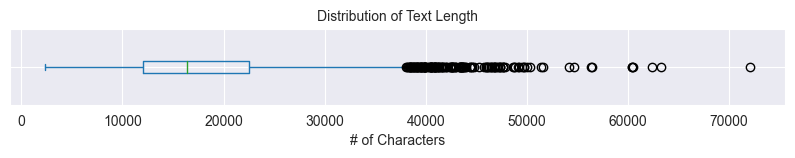

In [13]:
ax = df['text_length'].plot(kind='box', vert=False, figsize=(10, 1))
ax.set_title("Distribution of Text Length")
ax.set_xlabel("# of Characters")
ax.set_yticklabels([])
ax;

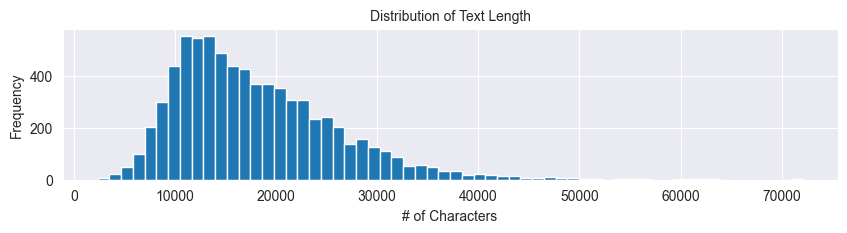

In [14]:
ax = df['text_length'].plot(kind='hist', bins=60, figsize=(10, 2));
ax.set_title("Distribution of Text Length")
ax.set_xlabel("# of Characters")
ax;

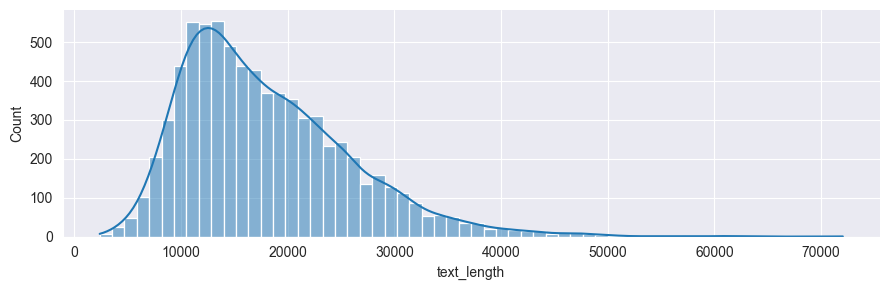

In [15]:
import seaborn as sns
sns.displot(df['text_length'], bins=60, kde=True, height=3, aspect=3);

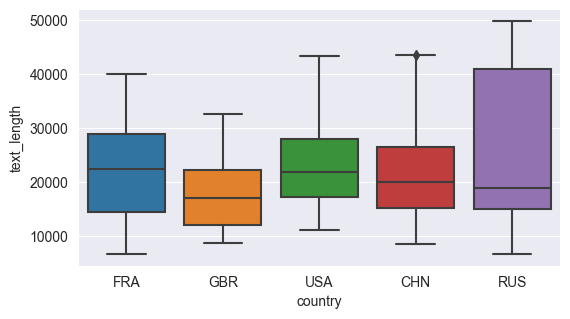

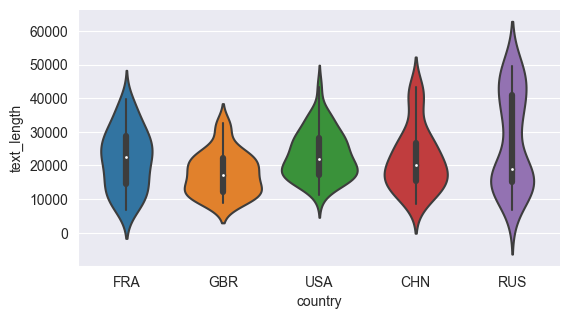

In [16]:
where = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS'])
g = sns.catplot(data=df[where], x="country", y="text_length", kind='box')
g.fig.set_size_inches(6, 3)
g.fig.set_dpi(100)
g = sns.catplot(data=df[where], x="country", y="text_length", kind='violin')
g.fig.set_size_inches(6, 3)
g.fig.set_dpi(100)

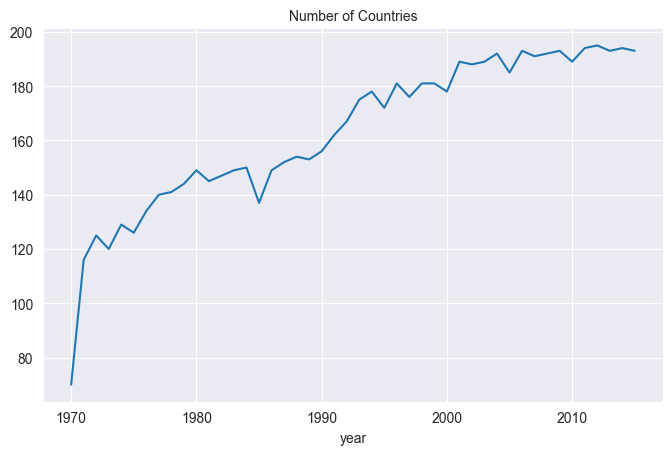

In [17]:
assert not df[['year', 'country']].duplicated().any()
df.groupby('year').size().plot(title="Number of Countries");

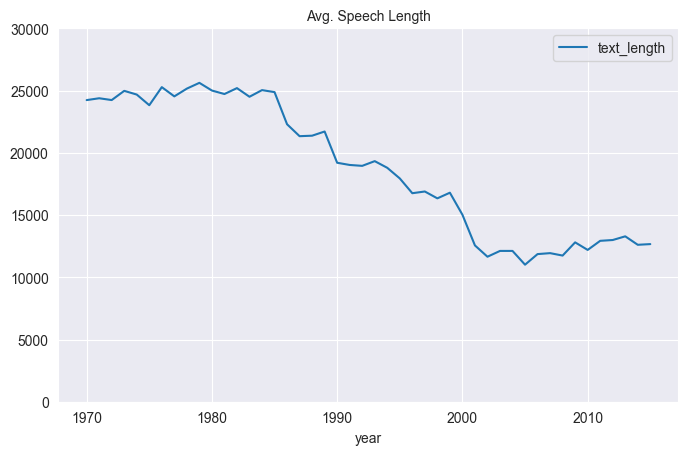

In [18]:
df.groupby('year').agg({'text_length': 'mean'}) \
  .plot(title="Avg. Speech Length", ylim=(0,30000));

### Word Frequency

In [ ]:
counts_df = count_tokens(df['tokens'])

In [ ]:
counts_df.head()

In [ ]:
def plot_wordcloud(frequency_dict):
    wc = wordcloud.WordCloud(background_color='white',
        #colormap='RdYlGn',
        colormap='tab20b',
        width=round(hlp.plot.STANDARD_WIDTH*100),
        height=round(hlp.plot.STANDARD_HEIGHT*100),
        max_words = 200, max_font_size=150,
        random_state=42
    )
    wc.generate_from_frequencies(frequency_dict)

    fig, ax = plt.subplots(figsize=(hlp.plot.STANDARD_WIDTH, hlp.plot.STANDARD_HEIGHT))
    ax.imshow(wc, interpolation='bilinear')
    #plt.title("XXX")
    plt.axis('off')

In [ ]:
plot_wordcloud(counts_df.to_dict()['frequency']);

### TF-IDF

In [ ]:
tf_idf_df = tf_idf(
    df=df,
    tokens_column='tokens',
    segment_columns = None,
    min_frequency_corpus=20,
    min_frequency_document=20,
)

In [ ]:
ax = tf_idf_df.sort_values(by='frequency', ascending=False).head(30)[['frequency']].plot(kind='barh', width=0.99)
ax.set_title("Frequency of Uni-Grams")
ax.set_xlabel("Frequency")
ax.invert_yaxis();

In [ ]:
ax = tf_idf_df.head(30)[['tf-idf']].plot(kind='barh', width=0.99)
ax.set_title("TF-IDF of Uni-Grams")
ax.set_xlabel("TF-IDF")
ax.invert_yaxis();

In [ ]:
plot_wordcloud(tf_idf_df.to_dict()['tf-idf']);

#### Per Year - 1970

In [ ]:
tf_idf_per_year = tf_idf(
    df=df,
    tokens_column='tokens',
    segment_columns = 'year',
    min_frequency_corpus=10,
    min_frequency_document=10,
)

In [ ]:
stop_words = ['twenty-fifth', 'twenty-five', 'twenty', 'fifth']
tokens_to_show = tf_idf_per_year.query('year == 1970').reset_index()
tokens_to_show = tokens_to_show[~tokens_to_show.token.isin(stop_words)]

In [ ]:
ax = tokens_to_show.head(30).set_index('token')[['tf-idf']].plot(kind='barh', width=0.99)
ax.set_title("TF-IDF of Uni-Grams - 1970")
ax.set_xlabel("TF-IDF")
ax.invert_yaxis();

In [ ]:
tokens_to_show = tokens_to_show[['token', 'tf-idf']].set_index('token')
tokens_to_show = tokens_to_show.to_dict()['tf-idf']

In [ ]:
plot_wordcloud(tokens_to_show);

#### Per Year - 2015

In [ ]:
stop_words = ['seventieth']
tokens_to_show = tf_idf_per_year.query('year == 2015').reset_index()
tokens_to_show = tokens_to_show[~tokens_to_show.token.isin(stop_words)]

In [ ]:
ax = tokens_to_show.head(30).set_index('token')[['tf-idf']].plot(kind='barh', width=0.99)
ax.set_title("TF-IDF of Uni-Grams - 2015")
ax.set_xlabel("TF-IDF")
ax.invert_yaxis();

In [ ]:
tokens_to_show = tokens_to_show[['token', 'tf-idf']].set_index('token')
tokens_to_show = tokens_to_show.to_dict()['tf-idf']

In [ ]:
plot_wordcloud(tokens_to_show);

### Keywords in Context

In [ ]:
contexts = get_context_from_keyword(
    documents=df[df['year'] == 2015]['text'],
    window_width=50,
    keyword='sdgs', random_seed=42
)
for x in contexts:
    print(x)

In [ ]:
contexts = get_context_from_keyword(
    documents=df[df['year'] == 2015]['text'],
    window_width=50,
    keyword='sids', random_seed=42
)
for x in contexts:
    print(x)

In [ ]:
contexts = get_context_from_keyword(
    documents=df[df['year'] == 2015]['text'],
    window_width=50,
    keyword='pv', random_seed=42
)
for x in contexts:
    print(x)

---

## Bi-Grams

In [ ]:
tf_idf_df = tf_idf(
    df=df,
    tokens_column='bi_grams',
    segment_columns = None,
    min_frequency_corpus=20,
    min_frequency_document=20,
)

In [ ]:
ax = tf_idf_df.sort_values(by='frequency', ascending=False).head(30)[['frequency']].plot(kind='barh', width=0.99)
ax.set_title("Frequency of Bi-Grams")
ax.set_xlabel("Frequency")
ax.invert_yaxis();

In [ ]:
ax = tf_idf_df.head(30)[['tf-idf']].plot(kind='barh', width=0.99)
ax.set_title("TF-IDF of Bi-Grams")
ax.set_xlabel("TF-IDF")
ax.invert_yaxis();

#### By Year

In [ ]:
tf_idf_per_year = tf_idf(
    df=df,
    tokens_column='bi_grams',
    segment_columns = 'year',
    min_frequency_corpus=3,
    min_frequency_document=3,
)

In [ ]:
stop_words = ['twenty-fifth anniversary', 'twenty-five years', 'twenty years', 'twenty fifth']
tokens_to_show = tf_idf_per_year.query('year == 1970').reset_index()
tokens_to_show = tokens_to_show[~tokens_to_show.token.isin(stop_words)]
tokens_to_show = tokens_to_show[['token', 'tf-idf']].set_index('token')
tokens_to_show = tokens_to_show.to_dict()['tf-idf']
plot_wordcloud(tokens_to_show);

In [ ]:
stop_words = ['seventieth anniversary']
tokens_to_show = tf_idf_per_year.query('year == 2015').reset_index()
tokens_to_show = tokens_to_show[~tokens_to_show.token.isin(stop_words)]
tokens_to_show = tokens_to_show[['token', 'tf-idf']].set_index('token')
tokens_to_show = tokens_to_show.to_dict()['tf-idf']
plot_wordcloud(tokens_to_show);

In [ ]:
stop_words = ['seventieth anniversary']
#tokens_to_show = tf_idf_per_year.query('year == 2015').reset_index()
tokens_to_show = tf_idf_per_year.reset_index()
tokens_to_show = tokens_to_show[~tokens_to_show.token.isin(stop_words)]

# filter for "climate"
tokens_to_show = tokens_to_show[tokens_to_show['token'].str.contains('climate')]
tokens_to_show

In [ ]:
tokens_to_show = tokens_to_show[['token', 'tf-idf']].set_index('token')
tokens_to_show = tokens_to_show.to_dict()['tf-idf']
plot_wordcloud(tokens_to_show);

---

# Count Keywords Over Time

In [ ]:
keyword_count_over_time = count_keywords_by(
    df=df,
    by='year',
    tokens='tokens',
    keywords = ['nuclear', 'terrorism', 'climate', 'freedom'],
)
keyword_count_over_time.head()

In [ ]:
ax = keyword_count_over_time.plot(kind='line')
ax.set_title("Keyword count over time")
ax.set_ylabel("# of Occurrences")

In [ ]:
keyword_count_over_time = count_keywords_by(
    df=df,
    by='year',
    tokens='bi_grams',
    keywords = ['climate change', 'human rights', 'middle east'],
)
keyword_count_over_time.head()

In [ ]:
ax = keyword_count_over_time.plot(kind='line')
ax.set_title("Keyword count over time")
ax.set_ylabel("# of Occurrences")

In [ ]:
contexts = get_context_from_keyword(
    documents=df[df['year'] <= 1980]['text'],
    window_width=50,
    keyword='human rights', random_seed=42
)
for x in contexts:
    print(x)

---

In [ ]:
keywords = ['terrorism', 'terrorist', 'nuclear', 'war', 'oil',
            'syria', 'syrian', 'refugees', 'migration', 'peacekeeping', 
            'humanitarian', 'climate', 'change', 'sustainable', 'sdgs']  

freq_df = count_keywords_by(df, by='year', tokens='tokens', keywords=keywords)
freq_df.head()

In [ ]:
df.groupby('year')['num_tokens'].sum().head()

In [ ]:
# compute relative frequencies based on total number of tokens per year
freq_df = freq_df.div(df.groupby('year')['num_tokens'].sum(), axis=0)
# apply square root as sublinear filter for better contrast
freq_df = freq_df.apply(np.sqrt)
freq_df.head()

In [ ]:
plt.figure(figsize=(10, 3))
sns.set(font_scale=1)
sns.heatmap(data=freq_df.T, 
            xticklabels=True, yticklabels=True, cbar=False, cmap="Reds")
sns.set(font_scale=1);

---